In [1]:
import sys
sys.path.append('../../../')
import RdPCA.src.model as rdpca

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from scipy.io import mmread
from openTSNE import TSNE

In [2]:
exp_data = mmread('../../data/%s/matrix.mtx' % 'pbmc_10k_v3').toarray().astype(float)
exp_data_col = pd.read_csv('../../data/%s/barcodes.tsv' % 'pbmc_10k_v3')['x']
exp_data_row = pd.read_csv('../../data/%s/features.tsv' % 'pbmc_10k_v3')['x']
hvg = pd.read_csv('../../data/%s/hvg.vst.tsv' % 'pbmc_10k_v3', index_col=0)['x'].values
exp_data_meta = pd.read_csv('../../data/%s/meta.csv' % 'pbmc_10k_v3', index_col=0)
size_factor = exp_data_meta['nCount_RNA']/exp_data_meta['nCount_RNA'].mean()

In [10]:
device_cuda_list = [torch.device("cuda:{}".format(i)) for i in range(6)[::-1]]
torch.set_default_tensor_type(torch.FloatTensor)
dtype = torch.float32
data = pd.DataFrame(exp_data, columns=exp_data_col, index=exp_data_row)
expr_mat = torch.tensor(data.T.loc[:,hvg[:3000]].values, dtype=dtype)
cc_mat = torch.tensor(exp_data_meta.loc[:,['S.Score', 'G2M.Score']].values, dtype=dtype)
sf = torch.tensor(size_factor, dtype=dtype)
batch_mat = torch.tensor(np.zeros((expr_mat.shape[0],1)), dtype=dtype)
device = device_cuda_list[3]

In [11]:
import imp
imp.reload(rdpca)
torch.manual_seed(0)
n_lat = 20
red = rdpca.fit_pca_linear(expr_mat, n_lat, cc_mat, sf, batch_mat, device=device)

step 0: loss -954.91
step 50: loss -2334.25
step 100: loss -2388.90
step 150: loss -2399.18


In [10]:
np.savetxt('rdpca.csv', red.detach().cpu().numpy(), delimiter=',')

# RdPCA

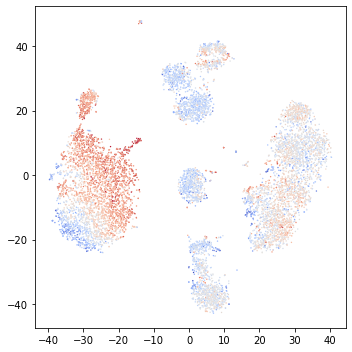

In [12]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(red.detach().cpu().numpy())

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2)
plt.tight_layout()

In [13]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_rdpca.csv')

# PCA

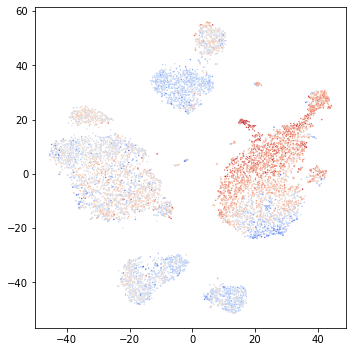

In [3]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('pca.csv', index_col=0).iloc[:,:20].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2)
plt.tight_layout()

In [4]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_pca.csv')

# SCT

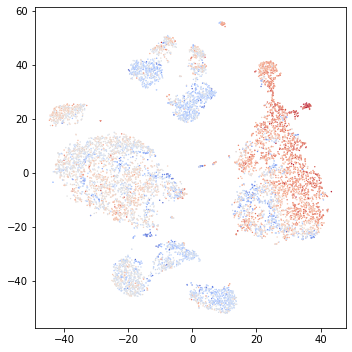

In [14]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('sct.csv', index_col=0).iloc[:,:20].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2)
plt.tight_layout()

In [15]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_sct.csv')

# GLM-PCA

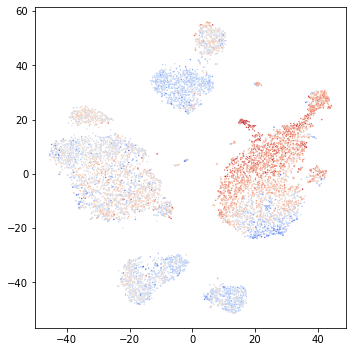

In [5]:
np.random.seed(0)
#tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('glmpca.csv', index_col=0).iloc[:,:20].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2)
plt.tight_layout()

In [6]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_glmpca.csv')

# ZINB-WaVE

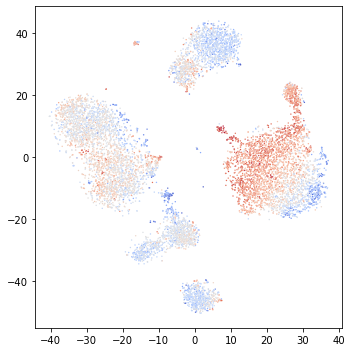

In [7]:
np.random.seed(0)
tsne2 = TSNE(n_jobs=4, perplexity=70).fit(pd.read_csv('zinbwave.csv', index_col=0).iloc[:,:20].values)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=tsne2[:,0], y=tsne2[:,1],
                hue=np.log(size_factor), legend=False,
                palette=sns.color_palette("coolwarm", as_cmap=True), s=2)
plt.tight_layout()

In [8]:
pd.DataFrame(tsne2, columns=['tSNE_1', 'tSNE_2']).to_csv('tsne_zinbwave.csv')

# Supp figure 3

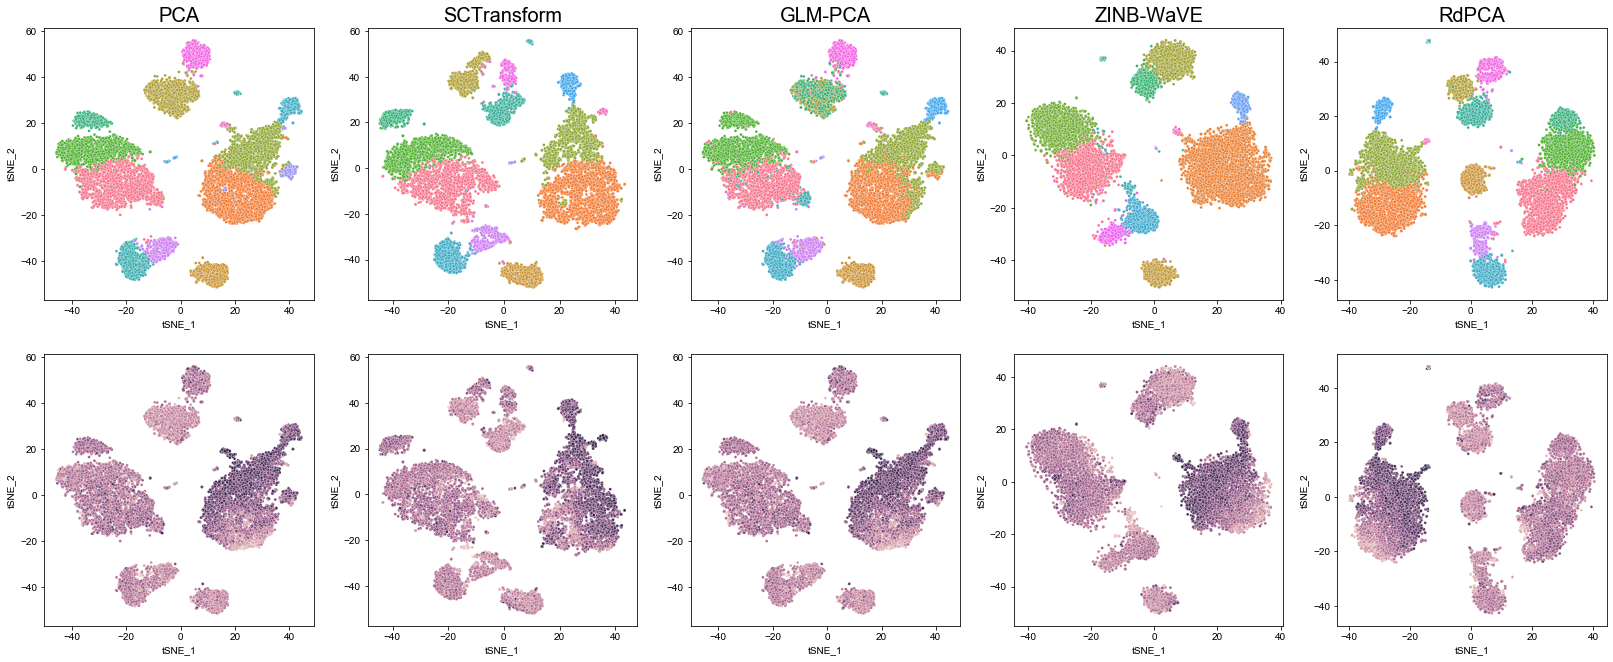

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(28, 11))
tsnes  = [pd.read_csv('tsne_%s.csv' % s, index_col=0) for s in ['pca', 'sct', 'glmpca', 'zinbwave', 'rdpca']]
clusters = [pd.read_csv('cluster_%s.csv' % s, index_col=0) for s in ['pca', 'sct', 'glmpca', 'zinbwave', 'rdpca']]
names = ['PCA', 'SCTransform', 'GLM-PCA', 'ZINB-WaVE', 'RdPCA']

# ref: https://matplotlib.org/gallery/api/font_family_rc_sgskip.html
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams["mathtext.fontset"] = 'dejavusans'

for i, name in enumerate(names):
    tsne = tsnes[i]
    cluster = clusters[i]
    sns.scatterplot(x='tSNE_1', y='tSNE_2', ax=axes[0,i], data=tsne, hue=cluster['seurat_clusters'].values.astype(str), legend=False, s=8)
    sns.scatterplot(x='tSNE_1', y='tSNE_2', ax=axes[1,i], data=tsne, hue=np.log(cluster['nCount_RNA'].values), legend=False, s=8)
    axes[0,i].set_title(name, fontsize=20)

